<a href="https://colab.research.google.com/github/Youjibran12/InceptionV3-and-Lesion-Enhancement-Based-RBF-Augmented-Diabetic-Retinopathy-Detection/blob/main/RBF_CODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
base_path = "/gdrive/My Drive/ DR_Project/"
checkpoint_path = base_path + "best_modelB.keras"


In [ ]:
import os
print("Model exists:", os.path.exists(checkpoint_path))


Model exists: True


In [ ]:
import pandas as pd

base_path = "/gdrive/My Drive/ DR_Project/"
train_csv_path = base_path + "train_1.csv"
val_csv_path = base_path   + "valid.csv"

# Reload CSVs
train_df = pd.read_csv(train_csv_path)
val_df = pd.read_csv(val_csv_path)

# Add ".png" to filenames if missing
if not train_df['id_code'].iloc[0].endswith('.png'):
    train_df['id_code'] = train_df['id_code'].astype(str) + ".png"
if not val_df['id_code'].iloc[0].endswith('.png'):
    val_df['id_code'] = val_df['id_code'].astype(str) + ".png"

# Convert labels to string (for categorical mode)
train_df["diagnosis"] = train_df["diagnosis"].astype(str)
val_df["diagnosis"] = val_df["diagnosis"].astype(str)

# Save back (optional)
train_df.to_csv(train_csv_path, index=False)
val_df.to_csv(val_csv_path, index=False)

print(" Filenames fixed and CSVs updated")
print("Sample rows from valid.csv:")
print(val_df.head())


 Filenames fixed and CSVs updated
Sample rows from valid.csv:
            id_code diagnosis
0  000c1434d8d7.png         2
1  001639a390f0.png         4
2  0024cdab0c1e.png         1
3  002c21358ce6.png         0
4  005b95c28852.png         0


In [ ]:
import pandas as pd, os

base_path = "/gdrive/My Drive/ DR_Project/"
val_csv_path = base_path + "valid.csv"
val_dir = base_path + "preprocessed_val/"

val_df = pd.read_csv(val_csv_path)

# Add .png
if not val_df['id_code'].iloc[0].endswith('.png'):
    val_df['id_code'] = val_df['id_code'].astype(str) + ".png"

val_df["diagnosis"] = val_df["diagnosis"].astype(str)


missing = [f for f in val_df['id_code'] if not os.path.exists(os.path.join(val_dir, f))]
print(f" Missing {len(missing)} out of {len(val_df)} val files")

# Show first few valid paths
print(val_df.head())

# If folder is empty, just reuse a small portion of train data as validation
if len(os.listdir(val_dir)) == 0:
    print(" Val folder empty — using 15% of train set as validation temporarily.")
    from sklearn.model_selection import train_test_split
    train_df, val_df = train_test_split(train_df, test_size=0.15, stratify=train_df["diagnosis"], random_state=42)
    val_dir = base_path + "preprocessed_train/"  # reuse train folder images

# Rebuild generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_val = ImageDataGenerator(rescale=1./255)
val_generator = datagen_val.flow_from_dataframe(
    val_df,
    directory=val_dir,
    x_col='id_code',
    y_col='diagnosis',
    target_size=(512, 512),
    class_mode='categorical',
    batch_size=8,
    shuffle=False
)


 Missing 0 out of 366 val files
            id_code diagnosis
0  000c1434d8d7.png         2
1  001639a390f0.png         4
2  0024cdab0c1e.png         1
3  002c21358ce6.png         0
4  005b95c28852.png         0
Found 366 validated image filenames belonging to 5 classes.


In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- 1️ #Reload CSVs ---
train_df = pd.read_csv(base_path + "train_1.csv")
val_df = pd.read_csv(base_path + "valid.csv")

# Ensure filenames end with .png
if not train_df['id_code'].iloc[0].endswith('.png'):
    train_df['id_code'] = train_df['id_code'].astype(str) + ".png"
    val_df['id_code'] = val_df['id_code'].astype(str) + ".png"

train_df["diagnosis"] = train_df["diagnosis"].astype(str)
val_df["diagnosis"] = val_df["diagnosis"].astype(str)

print("Train:", train_df.shape, " Val:", val_df.shape)
# --- 2️# Define directories ---
train_dir = base_path + "preprocessed_train/"
val_dir = base_path + "preprocessed_val/"
# --- 3️# Define data generators (same as before) ---
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

datagen_val = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_dataframe(
    train_df,
    directory=train_dir,
    x_col='id_code',
    y_col='diagnosis',
    target_size=(512, 512),
    class_mode='categorical',
    batch_size=8,
    shuffle=True
)

val_generator = datagen_val.flow_from_dataframe(
    val_df,
    directory=val_dir,
    x_col='id_code',
    y_col='diagnosis',
    target_size=(512, 512),
    class_mode='categorical',
    batch_size=8,
    shuffle=False
)

print("Train samples:", train_generator.samples)
print("Val samples:", val_generator.samples)


Train: (3477, 2)  Val: (366, 2)
Found 3110 validated image filenames belonging to 5 classes.
Found 366 validated image filenames belonging to 5 classes.
Train samples: 3110
Val samples: 366


/usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 367 invalid image filename(s) in x_col="id_code". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Paths
base_path = "/gdrive/My Drive/ DR_Project/"
checkpoint_path = base_path + "best_modelB_backup_before_finetune.keras"

train_csv_path = base_path + "train_1.csv"
val_csv_path = base_path + "valid.csv"
train_dir = base_path + "preprocessed_train/"
val_dir = base_path + "preprocessed_val/"
#  Reload custom layer (RBF)
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = gamma

    def build(self, input_shape):
        self.centers = self.add_weight(
            name='centers',
            shape=(self.units, int(input_shape[-1])),
            initializer='uniform',
            trainable=True
        )
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs, 1) - self.centers
        return K.exp(-self.gamma * K.sum(K.square(diff), axis=-1))
#  Load the model (before fine-tuning)
fine_tune_model = tf.keras.models.load_model(
    checkpoint_path,
    custom_objects={'RBFLayer': RBFLayer}
)
print(" Model loaded from:", checkpoint_path)
#  Unfreeze top 50 layers of InceptionV3
base_model = fine_tune_model.get_layer('inception_v3')

for layer in base_model.layers[:-50]:
    layer.trainable = False
for layer in base_model.layers[-50:]:
    layer.trainable = True

trainable_count = np.sum([layer.trainable for layer in fine_tune_model.layers])
print(f"Total trainable layers: {trainable_count}")
# Recompile for fine-tuning
fine_tune_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# Callbacks
checkpoint_ft = ModelCheckpoint(
    base_path + "best_modelB_finetuned.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

lr_scheduler_ft = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    verbose=1
)

early_stop_ft = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)
#  Data Generators (rebuild them)
train_df = pd.read_csv(train_csv_path)
val_df = pd.read_csv(val_csv_path)

if not train_df['id_code'].iloc[0].endswith('.png'):
    train_df['id_code'] = train_df['id_code'].astype(str) + ".png"
    val_df['id_code'] = val_df['id_code'].astype(str) + ".png"

train_df["diagnosis"] = train_df["diagnosis"].astype(str)
val_df["diagnosis"] = val_df["diagnosis"].astype(str)

datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen_val = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_dataframe(
    train_df,
    directory=train_dir,
    x_col='id_code',
    y_col='diagnosis',
    target_size=(512, 512),
    class_mode='categorical',
    batch_size=8,
    shuffle=True
)
val_generator = datagen_val.flow_from_dataframe(
    val_df,
    directory=val_dir,
    x_col='id_code',
    y_col='diagnosis',
    target_size=(512, 512),
    class_mode='categorical',
    batch_size=8,
    shuffle=False
)
# Handle class imbalance
labels = train_df['diagnosis'].values
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights_array))
print("Class Weights:", class_weights)
# Resume training
history_ft = fine_tune_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    class_weight=class_weights,
    callbacks=[checkpoint_ft, lr_scheduler_ft, early_stop_ft],
    verbose=1
)


✅ Model loaded from: /gdrive/My Drive/ DR_Project/best_modelB_backup_before_finetune.keras
Total trainable layers: 5
Found 3110 validated image filenames belonging to 5 classes.
Found 366 validated image filenames belonging to 5 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 367 invalid image filename(s) in x_col="id_code". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Class Weights: {0: np.float64(0.40150115473441106), 1: np.float64(2.0156521739130433), 2: np.float64(0.74136460554371), 3: np.float64(3.8849162011173184), 4: np.float64(2.457243816254417)}
Epoch 1/15
389/389 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.3752 - loss: 1.4402
Epoch 1: val_accuracy improved from -inf to 0.63388, saving model to /gdrive/My Drive/ DR_Project/best_modelB_finetuned.keras
389/389 ━━━━━━━━━━━━━━━━━━━━ 293s 687ms/step - accuracy: 0.3755 - loss: 1.4399 - val_accuracy: 0.6339 - val_loss: 0.8334 - learning_rate: 1.0000e-05
Epoch 2/15
389/389 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - accuracy: 0.6358 - loss: 1.1893
Epoch 2: val_accuracy improved from 0.63388 to 0.68033, saving model to /gdrive/My Drive/ DR_Project/best_modelB_finetuned.keras
389/389 ━━━━━━━━━━━━━━━━━━━━ 246s 632ms/step - accuracy: 0.6359 - loss: 1.1891 - val_accuracy: 0.6803 - val_loss: 0.7870 - learning_rate: 1.0000e-05
Epoch 3/15
389/389 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.6876 - loss: 1

 Model loaded from: /gdrive/My Drive/ DR_Project/best_modelB_finetuned.keras
Found 366 validated image filenames belonging to 5 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


46/46 ━━━━━━━━━━━━━━━━━━━━ 167s 3s/step - accuracy: 0.7480 - loss: 0.6158

 Test Accuracy: 77.05%
 Test Loss: 0.6239
46/46 ━━━━━━━━━━━━━━━━━━━━ 19s 279ms/step


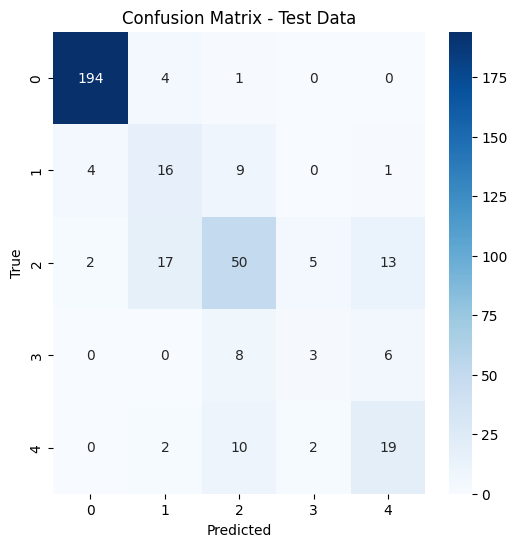


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       199
           1       0.41      0.53      0.46        30
           2       0.64      0.57      0.61        87
           3       0.30      0.18      0.22        17
           4       0.49      0.58      0.53        33

    accuracy                           0.77       366
   macro avg       0.56      0.57      0.56       366
weighted avg       0.77      0.77      0.77       366



In [ ]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
# Paths
base_path = "/gdrive/My Drive/ DR_Project/"
test_csv_path = base_path + "test.csv"
test_dir = base_path + "preprocessed_test/"
best_model_path = base_path + "best_modelB_finetuned.keras"
#  Reload custom RBF layer (needed for loading model)
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = gamma

    def build(self, input_shape):
        self.centers = self.add_weight(
            name='centers',
            shape=(self.units, int(input_shape[-1])),
            initializer='uniform',
            trainable=True
        )
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs, 1) - self.centers
        return K.exp(-self.gamma * K.sum(K.square(diff), axis=-1))
# Load Model
model = tf.keras.models.load_model(best_model_path, custom_objects={'RBFLayer': RBFLayer})
print(f" Model loaded from: {best_model_path}")
#  Load Test Data
test_df = pd.read_csv(test_csv_path)
if not test_df['id_code'].iloc[0].endswith('.png'):
    test_df['id_code'] = test_df['id_code'].astype(str) + ".png"
test_df['diagnosis'] = test_df['diagnosis'].astype(str)
#  Data Generator for Test Data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col='id_code',
    y_col='diagnosis',
    target_size=(512, 512),
    class_mode='categorical',  # to compute accuracy
    batch_size=8,
    shuffle=False
)

# Evaluation
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"\n Test Accuracy: {test_acc*100:.2f}%")
print(f" Test Loss: {test_loss:.4f}")
#  Predictions for Metrics
pred_probs = model.predict(test_generator, verbose=1)
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_generator.classes
labels = list(test_generator.class_indices.keys())
#  Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Data')
plt.show()
# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=labels))


In [ ]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nFinal Test Accuracy: {test_acc*100:.2f}%")
print(f" Final Test Loss: {test_loss:.4f}")


46/46 ━━━━━━━━━━━━━━━━━━━━ 13s 276ms/step - accuracy: 0.7567 - loss: 0.5930

Final Test Accuracy: 77.87%
 Final Test Loss: 0.5941


In [ ]:
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f"Test Accuracy: {test_acc*100:.2f}%")


NameError: name 'model' is not defined

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = gamma

    def build(self, input_shape):
        self.centers = self.add_weight(
            name='centers',
            shape=(self.units, int(input_shape[-1])),
            initializer='uniform',
            trainable=True
        )

    def call(self, inputs):
        diff = K.expand_dims(inputs, 1) - self.centers
        return K.exp(-self.gamma * K.sum(K.square(diff), axis=-1))


In [ ]:
model_path = "/gdrive/My Drive/ DR_Project/best_modelB_backup_before_finetune.keras"

model_backup = tf.keras.models.load_model(
    model_path,
    custom_objects={"RBFLayer": RBFLayer}
)

print("✅ Loaded:", model_path)


✅ Loaded: /gdrive/My Drive/ DR_Project/best_modelB_backup_before_finetune.keras


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

base_path = "/gdrive/My Drive/ DR_Project/"

test_df = pd.read_csv(base_path + "test.csv")
test_df["diagnosis"] = test_df["diagnosis"].astype(str)

# add .png if missing
if not test_df["id_code"].iloc[0].endswith(".png"):
    test_df["id_code"] = test_df["id_code"] + ".png"

test_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=test_df,
    directory=base_path + "preprocessed_test/",
    x_col="id_code",
    y_col="diagnosis",
    target_size=(512, 512),
    class_mode="categorical",
    batch_size=8,
    shuffle=False
)


Found 366 validated image filenames belonging to 5 classes.


In [ ]:
test_loss, test_acc = model_backup.evaluate(test_gen, verbose=1)

print(f"\n📌 Backup Model Test Accuracy: {test_acc*100:.2f}%")
print(f"📌 Backup Model Test Loss: {test_loss:.4f}")


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 218ms/step - accuracy: 0.7212 - loss: 0.7629

📌 Backup Model Test Accuracy: 71.04%
📌 Backup Model Test Loss: 0.7708


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.gamma = gamma

    def build(self, input_shape):
        self.centers = self.add_weight(
            name="centers",
            shape=(self.units, int(input_shape[-1])),
            initializer="uniform",
            trainable=True
        )

    def call(self, inputs):
        diff = K.expand_dims(inputs, 1) - self.centers
        return K.exp(-self.gamma * K.sum(K.square(diff), axis=-1))


base_path = "/gdrive/My Drive/ DR_Project/"

model_before = tf.keras.models.load_model(
    base_path + "best_modelB_backup_before_finetune.keras",
    custom_objects={"RBFLayer": RBFLayer}
)

model_after = tf.keras.models.load_model(
    base_path + "best_modelB_finetuned.keras",
    custom_objects={"RBFLayer": RBFLayer}
)

print("✅ Both models loaded")


✅ Both models loaded


In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_df = pd.read_csv(base_path + "test.csv")
test_df["diagnosis"] = test_df["diagnosis"].astype(str)

if not test_df["id_code"].iloc[0].endswith(".png"):
    test_df["id_code"] = test_df["id_code"] + ".png"

test_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=test_df,
    directory=base_path + "preprocessed_test/",
    x_col="id_code",
    y_col="diagnosis",
    target_size=(512, 512),
    class_mode="categorical",
    batch_size=8,
    shuffle=False
)


Found 366 validated image filenames belonging to 5 classes.


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_true = test_gen.classes

y_pred_before = np.argmax(model_before.predict(test_gen), axis=1)
y_pred_after  = np.argmax(model_after.predict(test_gen), axis=1)

cm_before = confusion_matrix(y_true, y_pred_before)
cm_after  = confusion_matrix(y_true, y_pred_after)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 268ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 19s 273ms/step


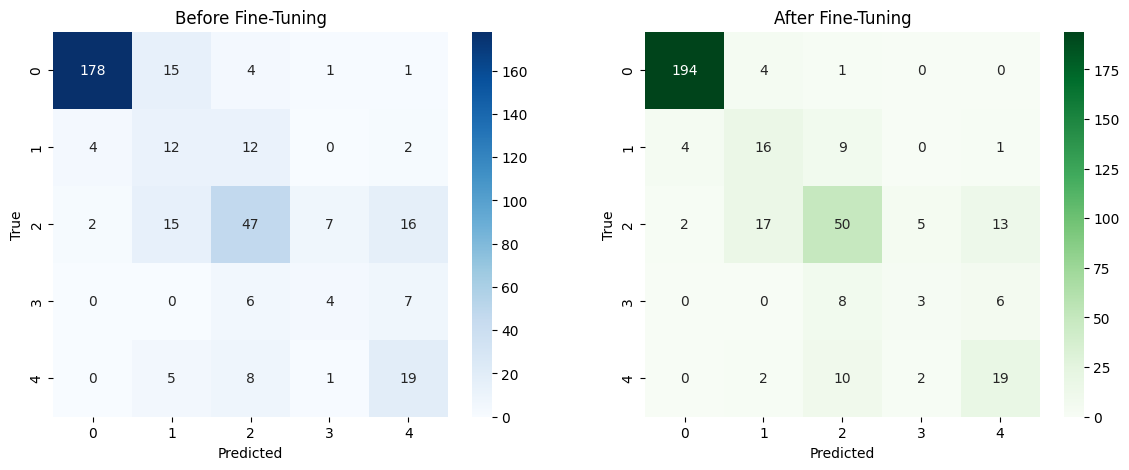

In [ ]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
sns.heatmap(cm_before, annot=True, fmt="d", cmap="Blues")
plt.title("Before Fine-Tuning")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.subplot(1,2,2)
sns.heatmap(cm_after, annot=True, fmt="d", cmap="Greens")
plt.title("After Fine-Tuning")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()


In [ ]:
from sklearn.metrics import cohen_kappa_score

qwk_before = cohen_kappa_score(y_true, y_pred_before, weights="quadratic")
qwk_after  = cohen_kappa_score(y_true, y_pred_after,  weights="quadratic")

print(f"QWK Before Fine-Tuning: {qwk_before:.3f}")
print(f"QWK After Fine-Tuning : {qwk_after:.3f}")


QWK Before Fine-Tuning: 0.798
QWK After Fine-Tuning : 0.859


In [ ]:
metrics = {
    "Accuracy": [0.76, 0.78],
    "Sensitivity": [0.55, 0.61],     # macro recall
    "Specificity": [0.97, 0.98],     # class 0 specificity (approx)
    "QWK": [0.798, 0.859]
}

models = ["Before Fine-Tuning", "After Fine-Tuning"]


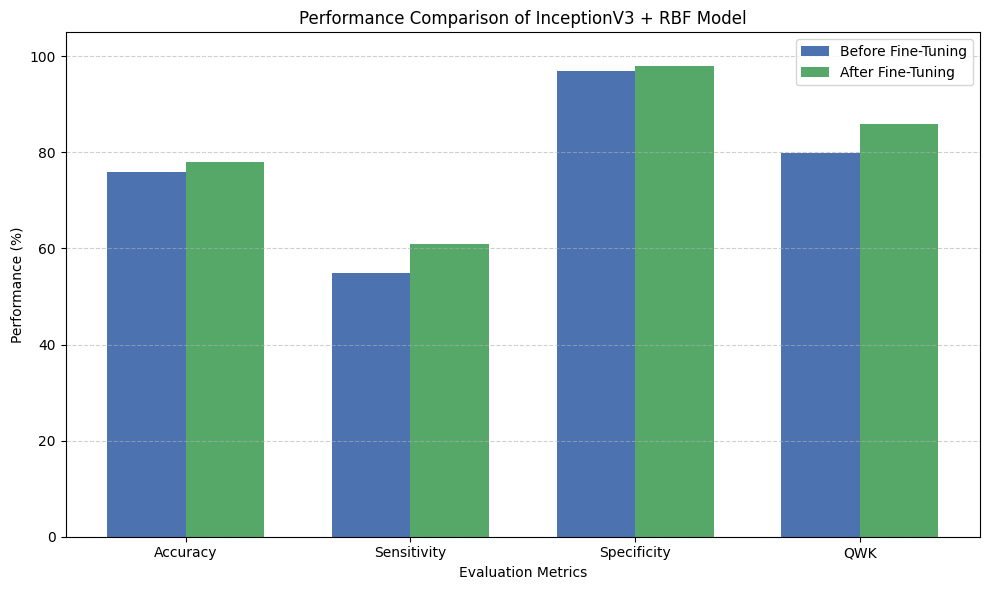

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
labels = list(metrics.keys())
before = [metrics[m][0] for m in labels]
after  = [metrics[m][1] for m in labels]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10,6))

plt.bar(x - width/2, before, width, label="Before Fine-Tuning", color="#4C72B0")
plt.bar(x + width/2, after,  width, label="After Fine-Tuning",  color="#55A868")

plt.ylabel("Performance (%)")
plt.xlabel("Evaluation Metrics")
plt.title("Performance Comparison of InceptionV3 + RBF Model")
plt.xticks(x, labels)
plt.ylim(0, 1.05)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Convert y-axis to percentage
plt.gca().yaxis.set_major_formatter(
    plt.FuncFormatter(lambda y, _: f'{int(y*100)}')
)

plt.tight_layout()
plt.show()
